#1- veri setinin çekilmesi ve Gerekli kütüphanelerin indirilmesi

In [7]:
# Gerekli kütüphanelerin kurulumu
!pip install transformers datasets torch scikit-learn nltk matplotlib seaborn TurkishStemmer sentencepiece

# Kütüphanelerin içe aktarılması
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os

from datasets import load_dataset
from nltk.corpus import stopwords
from TurkishStemmer import TurkishStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# NLTK gereksinimleri
nltk.download('stopwords')
nltk.download('punkt')

# Uyarıları kapatmak için (W&B vb.)
os.environ["WANDB_DISABLED"] = "true"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#2- veri seti temizlenmesi önişleme

In [8]:
# Türkçe durak kelimeler ve kök bulucu
stop_words = set(stopwords.words('turkish'))
stemmer = TurkishStemmer()

def veri_temizleme(metin):
    # 1. Küçük harfe çevir
    metin = str(metin).lower()

    # 2. Kullanıcı adlarını (@kullanici) temizle
    metin = re.sub(r'@\w+', '', metin)

    # 3. Sadece harfleri tut (Noktalama ve sayıları kaldır)
    # Not: Bu işlem kullanıcı adlarındaki @ işaretinden sonra kalanları da temizler
    metin = re.sub(r'[^a-zçğıöşü\s]', '', metin)

    # 4. Gereksiz boşlukları temizle (Birden fazla boşluğu tek boşluğa indir ve kenarları kırp)
    metin = re.sub(r'\s+', ' ', metin).strip()

    # 5. Kelimelere ayır
    kelimeler = metin.split()

    # 6. Stopwords temizliği ve Stemming (Kök bulma)
    temiz_kelimeler = []
    for kelime in kelimeler:
        if kelime not in stop_words:
            kok = stemmer.stem(kelime)
            temiz_kelimeler.append(kok)

    # 7. Tekrar birleştir
    return " ".join(temiz_kelimeler)

print("Temizleme fonksiyonu yeni adımlarla güncellendi.")

Temizleme fonksiyonu yeni adımlarla güncellendi.


#3- veri yükleme ve inceleme



--- İlk 5 Satır (Ham Veri) ---


,text,label,dataset
0,"ci̇haz; kamera, görüşme sesi̇, esteti̇k, arayü...",Positive,urun_yorumlari
1,Bu ırk yok olduğu için artık kendi kararlarını...,Notr,wiki
2,Çok güzellllllll bir tatil geçirdik hava çok g...,Positive,HUMIR
3,Rekabetçi bir ruha sahip olduğu bilinmektedir ...,Notr,wiki
4,;))) Bu filmi sewmeyen ölsün mü??? ;))) Kesin...,Positive,HUMIR



Veriler temizleniyor...
Temizleme tamamlandı!


/tmp/ipython-input-2514310648.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')


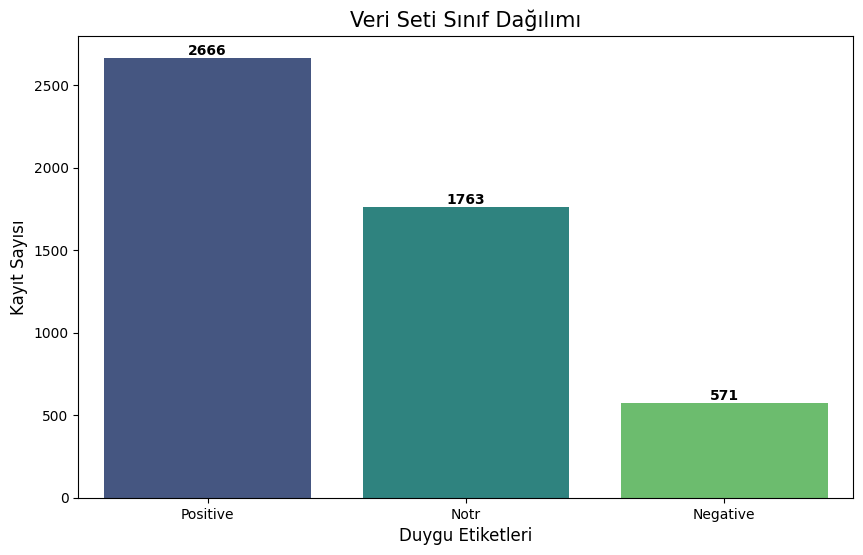

In [9]:
# Veri setini indir
dataset = load_dataset("winvoker/turkish-sentiment-analysis-dataset")
df = dataset['train'].to_pandas()

# Veri seti çok büyükse eğitim hızı için örneklem alıyoruz (Örn: 5000 adet)
df = df.sample(n=5000, random_state=42).reset_index(drop=True)

# İlk 5 satırı göster
print("\n--- İlk 5 Satır (Ham Veri) ---")
display(df.head())

# Temizleme işlemini uygula
print("\nVeriler temizleniyor...")
df['clean_text'] = df['text'].apply(veri_temizleme)
print("Temizleme tamamlandı!")

# Sınıf Dağılımını Görselleştirme
plt.figure(figsize=(10, 6))
counts = df['label'].value_counts()
ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')

plt.title('Veri Seti Sınıf Dağılımı', fontsize=15)
plt.ylabel('Kayıt Sayısı', fontsize=12)
plt.xlabel('Duygu Etiketleri', fontsize=12)

# Bar üzerine sayıları yazdırma
for i, v in enumerate(counts.values):
    ax.text(i, v + 20, str(v), ha='center', fontweight='bold')

plt.show()

#4- tekrar önişleme aşaması

In [10]:
# Etiketleri Sayısala Çevirme (Label Encoding)
# Örn: 'Positive' -> 2, 'Negative' -> 0
le = LabelEncoder()
df['label_id'] = le.fit_transform(df['label'])

print(f"Sınıf Haritası: {dict(zip(le.classes_, le.transform(le.classes_)))}")
num_labels = len(le.classes_)

# X ve y olarak ayırma
X = df['clean_text'].values.tolist()
y = df['label_id'].values.tolist()

# Eğitim ve Test olarak bölme (%80 Eğitim, %20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nEğitim Verisi Sayısı: {len(X_train)}")
print(f"Test Verisi Sayısı  : {len(X_test)}")

# PyTorch Dataset Sınıfı ve Metrik Fonksiyonu (Tüm modeller için ortak)
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

Sınıf Haritası: {'Negative': np.int64(0), 'Notr': np.int64(1), 'Positive': np.int64(2)}

Eğitim Verisi Sayısı: 4000
Test Verisi Sayısı  : 1000


#5- transformer modelleri

##5.1- BERTurk

In [20]:
model_adi_bert = "dbmdz/bert-base-turkish-cased"
print(f"\n>>> {model_adi_bert} Hazırlanıyor...")

# Tokenizer
tokenizer_bert = AutoTokenizer.from_pretrained(model_adi_bert)

# Veriyi Tokenize Etme
train_enc_bert = tokenizer_bert(X_train, truncation=True, padding=True, max_length=128)
test_enc_bert = tokenizer_bert(X_test, truncation=True, padding=True, max_length=128)

# Dataset Oluşturma
train_dataset_bert = SentimentDataset(train_enc_bert, y_train)
test_dataset_bert = SentimentDataset(test_enc_bert, y_test)

# Modeli Yükleme
model_bert = AutoModelForSequenceClassification.from_pretrained(model_adi_bert, num_labels=num_labels)

# Eğitim Argümanları
training_args_bert = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Trainer
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_dataset_bert,
    eval_dataset=test_dataset_bert,
    compute_metrics=compute_metrics,
)

# Eğitim
print("BERTurk Eğitimi Başlıyor...")
trainer_bert.train()

# Sonuçları Kaydetme
results_bert = trainer_bert.evaluate()
print("BERTurk Sonuçları:", results_bert)


>>> dbmdz/bert-base-turkish-cased Hazırlanıyor...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


BERTurk Eğitimi Başlıyor...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.295900,0.222259,0.912000,0.912829,0.913860,0.912000
2,0.225700,0.220884,0.936000,0.931401,0.936747,0.936000
3,0.090400,0.256559,0.922000,0.922425,0.923145,0.922000


BERTurk Sonuçları: {'eval_loss': 0.22088395059108734, 'eval_accuracy': 0.936, 'eval_f1': 0.9314011797554524, 'eval_precision': 0.9367470176881941, 'eval_recall': 0.936, 'eval_runtime': 6.6727, 'eval_samples_per_second': 149.863, 'eval_steps_per_second': 9.441, 'epoch': 3.0}


##5.2- XLM-RoBERTa

In [19]:
# --- Model 2: XLM-RoBERTa ---
model_adi_xlm = "xlm-roberta-base"
print(f"\n>>> {model_adi_xlm} Hazırlanıyor...")

# Tokenizer
tokenizer_xlm = AutoTokenizer.from_pretrained(model_adi_xlm)

# Veriyi Tokenize Etme
train_enc_xlm = tokenizer_xlm(X_train, truncation=True, padding=True, max_length=128)
test_enc_xlm = tokenizer_xlm(X_test, truncation=True, padding=True, max_length=128)

# Dataset Oluşturma
train_dataset_xlm = SentimentDataset(train_enc_xlm, y_train)
test_dataset_xlm = SentimentDataset(test_enc_xlm, y_test)

# Modeli Yükleme
model_xlm = AutoModelForSequenceClassification.from_pretrained(model_adi_xlm, num_labels=num_labels)

# Eğitim Argümanları
training_args_xlm = TrainingArguments(
    output_dir='./results_xlm',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=50
)

# Trainer
trainer_xlm = Trainer(
    model=model_xlm,
    args=training_args_xlm,
    train_dataset=train_dataset_xlm,
    eval_dataset=test_dataset_xlm,
    compute_metrics=compute_metrics,
)

# Eğitim
print("XLM-RoBERTa Eğitimi Başlıyor...")
trainer_xlm.train()

# Sonuçları Kaydetme
results_xlm = trainer_xlm.evaluate()
print("XLM-RoBERTa Sonuçları:", results_xlm)


>>> xlm-roberta-base Hazırlanıyor...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


XLM-RoBERTa Eğitimi Başlıyor...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.518600,0.450718,0.857000,0.853967,0.851697,0.857000
2,0.446100,0.529838,0.835000,0.837764,0.842036,0.835000
3,0.356400,0.426274,0.853000,0.849665,0.847647,0.853000


XLM-RoBERTa Sonuçları: {'eval_loss': 0.4262739419937134, 'eval_accuracy': 0.853, 'eval_f1': 0.8496646860804672, 'eval_precision': 0.8476466062380444, 'eval_recall': 0.853, 'eval_runtime': 6.1819, 'eval_samples_per_second': 161.764, 'eval_steps_per_second': 10.191, 'epoch': 3.0}


#5.3- DistilBERTurk

In [21]:
# --- Model 3: DistilBERTurk ---
model_adi_distil = "dbmdz/distilbert-base-turkish-cased"
print(f"\n>>> {model_adi_distil} Hazırlanıyor...")

# Tokenizer
tokenizer_distil = AutoTokenizer.from_pretrained(model_adi_distil)

# Veriyi Tokenize Etme
train_enc_distil = tokenizer_distil(X_train, truncation=True, padding=True, max_length=128)
test_enc_distil = tokenizer_distil(X_test, truncation=True, padding=True, max_length=128)

# Dataset Oluşturma
train_dataset_distil = SentimentDataset(train_enc_distil, y_train)
test_dataset_distil = SentimentDataset(test_enc_distil, y_test)

# Modeli Yükleme
model_distil = AutoModelForSequenceClassification.from_pretrained(model_adi_distil, num_labels=num_labels)

# Eğitim Argümanları
training_args_distil = TrainingArguments(
    output_dir='./results_distil',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Trainer
trainer_distil = Trainer(
    model=model_distil,
    args=training_args_distil,
    train_dataset=train_dataset_distil,
    eval_dataset=test_dataset_distil,
    compute_metrics=compute_metrics,
)

# Eğitim
print("DistilBERTurk Eğitimi Başlıyor...")
trainer_distil.train()

# Sonuçları Kaydetme
results_distil = trainer_distil.evaluate()
print("DistilBERTurk Sonuçları:", results_distil)


>>> dbmdz/distilbert-base-turkish-cased Hazırlanıyor...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/distilbert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


DistilBERTurk Eğitimi Başlıyor...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.352100,0.263956,0.901000,0.896964,0.895070,0.901000
2,0.241100,0.246333,0.913000,0.909654,0.908435,0.913000
3,0.099800,0.277212,0.914000,0.912067,0.911555,0.914000


DistilBERTurk Sonuçları: {'eval_loss': 0.2463328242301941, 'eval_accuracy': 0.913, 'eval_f1': 0.9096544063400502, 'eval_precision': 0.9084350502135585, 'eval_recall': 0.913, 'eval_runtime': 3.3519, 'eval_samples_per_second': 298.334, 'eval_steps_per_second': 18.795, 'epoch': 3.0}


#6- Görselleştirme



##6.1- Confusion Matrix



BERTurk (Model 1) tahminleri alınıyor...


XLM-RoBERTa (Model 2) tahminleri alınıyor...


DistilBERTurk (Model 3) tahminleri alınıyor...


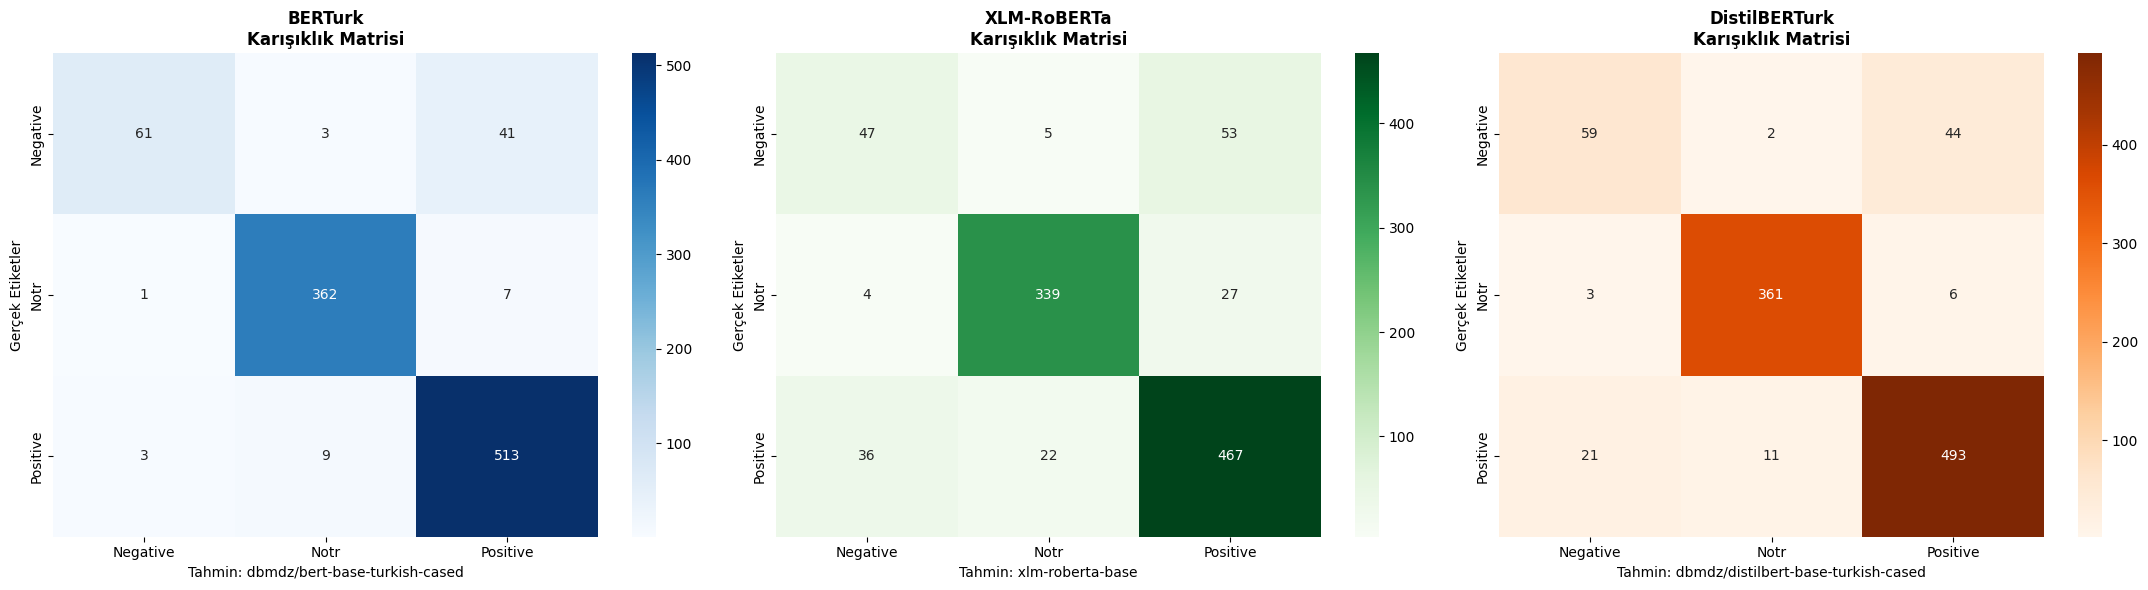

In [22]:
# --- 1. Tahminleri Alma ---

print("BERTurk (Model 1) tahminleri alınıyor...")
preds_bert_output = trainer_bert.predict(test_dataset_bert)
y_pred_bert = preds_bert_output.predictions.argmax(-1)

print("XLM-RoBERTa (Model 2) tahminleri alınıyor...")
preds_xlm_output = trainer_xlm.predict(test_dataset_xlm)
y_pred_xlm = preds_xlm_output.predictions.argmax(-1)

print("DistilBERTurk (Model 3) tahminleri alınıyor...")
preds_distil_output = trainer_distil.predict(test_dataset_distil)
y_pred_distil = preds_distil_output.predictions.argmax(-1)

# --- 2. Matrisleri Hesaplama ---
cm_bert = confusion_matrix(y_test, y_pred_bert)
cm_xlm = confusion_matrix(y_test, y_pred_xlm)
cm_distil = confusion_matrix(y_test, y_pred_distil)

# --- 3. Görselleştirme (Yan Yana 3 Grafik) ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Grafik 1: BERTurk (Mavi)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title(f'BERTurk\nKarışıklık Matrisi', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Gerçek Etiketler')
axes[0].set_xlabel('Tahmin: ' + model_adi_bert)

# Grafik 2: XLM-RoBERTa (Yeşil)
sns.heatmap(cm_xlm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title(f'XLM-RoBERTa\nKarışıklık Matrisi', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Gerçek Etiketler')
axes[1].set_xlabel('Tahmin: ' + model_adi_xlm)

# Grafik 3: DistilBERTurk (Turuncu/Kırmızı)
sns.heatmap(cm_distil, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[2])
axes[2].set_title(f'DistilBERTurk\nKarışıklık Matrisi', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Gerçek Etiketler')
axes[2].set_xlabel('Tahmin: ' + model_adi_distil)

plt.tight_layout()
plt.show()

##6.2- Performans karşılaştırma grafiği

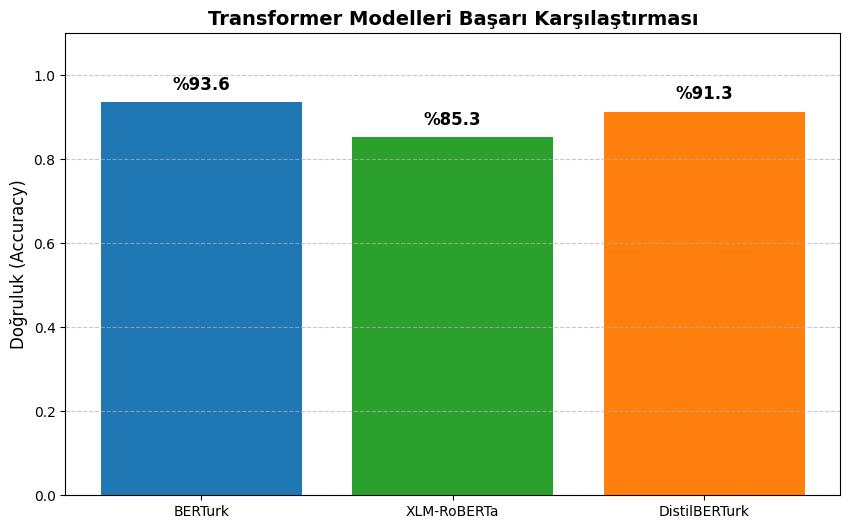

In [23]:
import matplotlib.pyplot as plt

# Sonuçları listeleme
model_isimleri = ['BERTurk', 'XLM-RoBERTa', 'DistilBERTurk']
basarimlar = [
    results_bert['eval_accuracy'],
    results_xlm['eval_accuracy'],
    results_distil['eval_accuracy']
]

# Grafik Çizimi
plt.figure(figsize=(10, 6))
renkler = ['#1f77b4', '#2ca02c', '#ff7f0e'] # Mavi, Yeşil, Turuncu
bars = plt.bar(model_isimleri, basarimlar, color=renkler)

plt.title('Transformer Modelleri Başarı Karşılaştırması', fontsize=14, fontweight='bold')
plt.ylabel('Doğruluk (Accuracy)', fontsize=12)
plt.ylim(0, 1.1)

# Barların üzerine yüzdeleri yazma
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02,
             f"%{yval*100:.1f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#6.3- Tüm Metriklerin Tablo Halinde Karşılaştırılması

In [24]:
def metrikleri_getir(results, model_adi):
    return {
        'Model': model_adi,
        'Accuracy': results['eval_accuracy'],
        'Precision': results['eval_precision'],
        'Recall': results['eval_recall'],
        'F1-Score': results['eval_f1']
    }

# Verileri topla
performans_verisi = [
    metrikleri_getir(results_bert, 'BERTurk'),
    metrikleri_getir(results_xlm, 'XLM-RoBERTa'),
    metrikleri_getir(results_distil, 'DistilBERTurk')
]

# DataFrame oluştur
df_performans = pd.DataFrame(performans_verisi)

print("\n--- Model Performans Karşılaştırma Tablosu ---")
display(df_performans)


--- Model Performans Karşılaştırma Tablosu ---


,Model,Accuracy,Precision,Recall,F1-Score
0,BERTurk,0.936,0.936747,0.936,0.931401
1,XLM-RoBERTa,0.853,0.847647,0.853,0.849665
2,DistilBERTurk,0.913,0.908435,0.913,0.909654


#6.4- Eğitim Kayıp (Loss) Grafiği

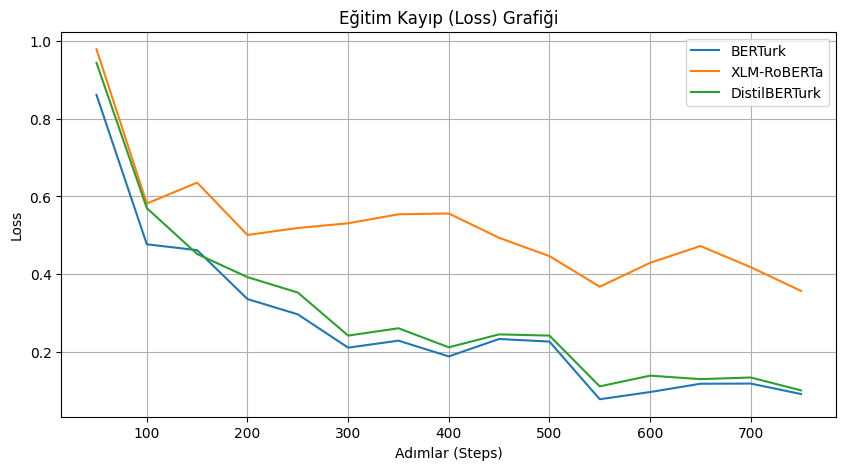

In [25]:
def plot_loss(trainer, model_name):
    history = trainer.state.log_history
    losses = [x['loss'] for x in history if 'loss' in x]
    steps = [x['step'] for x in history if 'loss' in x]

    plt.plot(steps, losses, label=model_name)

plt.figure(figsize=(10, 5))
plot_loss(trainer_bert, 'BERTurk')
plot_loss(trainer_xlm, 'XLM-RoBERTa')
plot_loss(trainer_distil, 'DistilBERTurk')

plt.title('Eğitim Kayıp (Loss) Grafiği')
plt.xlabel('Adımlar (Steps)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()